<a href="https://colab.research.google.com/github/sameekshya1999/lstm/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Splitting dataset...
Initializing model...
Starting training...
Epoch 1/3, Train Loss: 0.7478, Train Acc: 0.9123, Val Loss: 0.6553, Val Acc: 0.9152
Epoch 2/3, Train Loss: 0.6029, Train Acc: 0.9174, Val Loss: 0.6642, Val Acc: 0.9173
Epoch 3/3, Train Loss: 0.5735, Train Acc: 0.9188, Val Loss: 0.6643, Val Acc: 0.9184


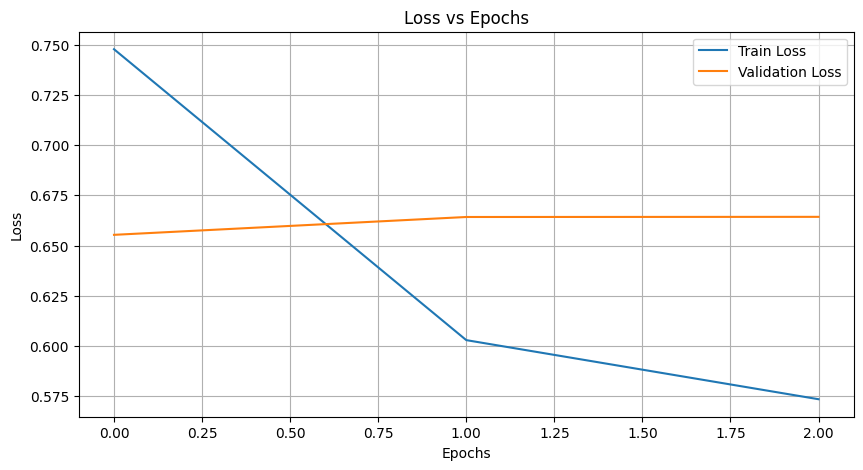

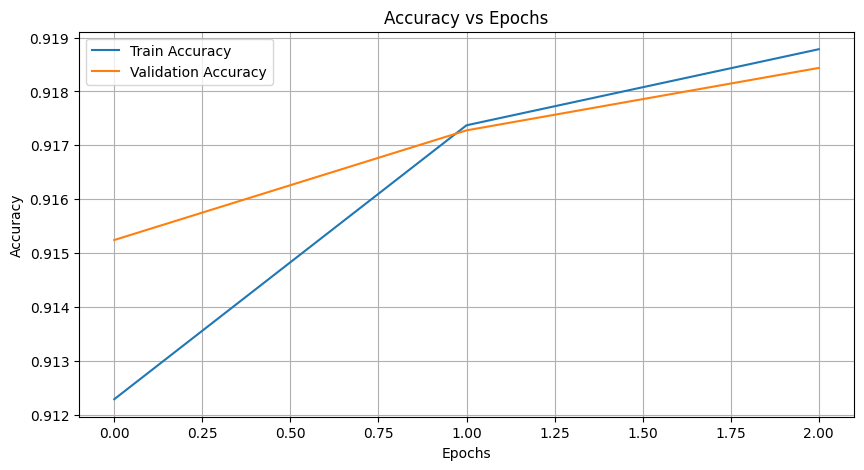

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare dataset
def prepare_data(texts, tokenizer, seq_length):
    tokenized_texts = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, add_special_tokens=True)
    input_ids = tokenized_texts["input_ids"]

    X, y = [], []
    for sentence in input_ids:
        for i in range(seq_length, len(sentence)):
            X.append(sentence[i-seq_length:i])
            y.append(sentence[i])

    # Pad sequences for consistent length
    X = pad_sequence(X, batch_first=True, padding_value=tokenizer.pad_token_id)
    y = torch.tensor(y)

    return X, y

# Define tokenizer and vocab
class SimpleTokenizer:
    def __init__(self):
        self.vocab = {}
        self.pad_token_id = 0

    def fit(self, texts):
        unique_tokens = set(word for text in texts for word in text.split())
        self.vocab = {word: idx + 1 for idx, word in enumerate(unique_tokens)}  # Reserve 0 for padding
        self.vocab["<PAD>"] = self.pad_token_id

    def encode(self, text):
        return [self.vocab.get(word, self.pad_token_id) for word in text.split()]

    def __call__(self, texts, return_tensors="pt", truncation=True, padding=True, add_special_tokens=False):
        encoded = [self.encode(text) for text in texts]
        max_length = max(len(seq) for seq in encoded)
        padded = [seq + [self.pad_token_id] * (max_length - len(seq)) for seq in encoded]
        return {"input_ids": torch.tensor(padded)}

# Initialize tokenizer
tokenizer = SimpleTokenizer()

# Load dataset and tokenize
print("Loading dataset...")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
texts = dataset[:1000]["text"]  # Use a subset for efficiency
tokenizer.fit(texts)

seq_length = 50
X, y = prepare_data(texts, tokenizer, seq_length)

# Split dataset into train and validation sets
print("Splitting dataset...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        logits = self.fc(lstm_out[:, -1, :])  # Use the last hidden state
        return logits

# Initialize the model
print("Initializing model...")
vocab_size = len(tokenizer.vocab)
embedding_dim = 128
hidden_dim = 256

model = LSTMModel(vocab_size, embedding_dim, hidden_dim).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
print("Starting training...")
epochs = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=-1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
            preds = outputs.argmax(dim=-1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()
